## Задача по прогнозированию болезни сердца https://archive.ics.uci.edu/ml/datasets/heart+Disease

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

import seaborn as sns
sns.set(font_scale=1.3)

from matplotlib import pyplot as plt

from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

import numpy as np

from warnings import simplefilter
from xgboost import XGBClassifier

from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix, recall_score, precision_score

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

from category_encoders.cat_boost import CatBoostEncoder
simplefilter(action='ignore', category=FutureWarning)

import xgboost as xgb
from xgboost import XGBClassifier

In [3]:
SEED = 0

In [4]:
df = pd.read_csv('heart.dat',
                 names=[
                     'age', 'sex', 'chess_pain_type', 'rg_blood_pressure',
                     'sr_cholestoral', 'fg_blood_sugar', 'cardio',
                     'max_heart_rate', 'exercise_ind_angina', 'oldpeak',
                     'slpe_peak_exercize', 'ves_number', 'thal', 'ill'
                 ],
                 header=None,
                 sep=' ',
                 index_col=False)

In [5]:
df.head()

,age,sex,chess_pain_type,rg_blood_pressure,sr_cholestoral,fg_blood_sugar,cardio,max_heart_rate,exercise_ind_angina,oldpeak,slpe_peak_exercize,ves_number,thal,ill
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


## EDA

In [6]:
df.describe()

,age,sex,chess_pain_type,rg_blood_pressure,sr_cholestoral,fg_blood_sugar,cardio,max_heart_rate,exercise_ind_angina,oldpeak,slpe_peak_exercize,ves_number,thal,ill
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,1.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,1.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,1.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,1.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,2.000000


In [7]:
df['ill'] -= 1

In [8]:
df.nunique()

age                     41
sex                      2
chess_pain_type          4
rg_blood_pressure       47
sr_cholestoral         144
fg_blood_sugar           2
cardio                   3
max_heart_rate          90
exercise_ind_angina      2
oldpeak                 39
slpe_peak_exercize       3
ves_number               4
thal                     3
ill                      2
dtype: int64

In [9]:
num_features = [
    'age', 'rg_blood_pressure', 'sr_cholestoral', 'max_heart_rate', 'oldpeak'
]
cat_features = [
    feature for feature in df.columns if feature not in num_features + ['ill']
]

In [10]:
df.dtypes

age                    float64
sex                    float64
chess_pain_type        float64
rg_blood_pressure      float64
sr_cholestoral         float64
fg_blood_sugar         float64
cardio                 float64
max_heart_rate         float64
exercise_ind_angina    float64
oldpeak                float64
slpe_peak_exercize     float64
ves_number             float64
thal                   float64
ill                      int64
dtype: object

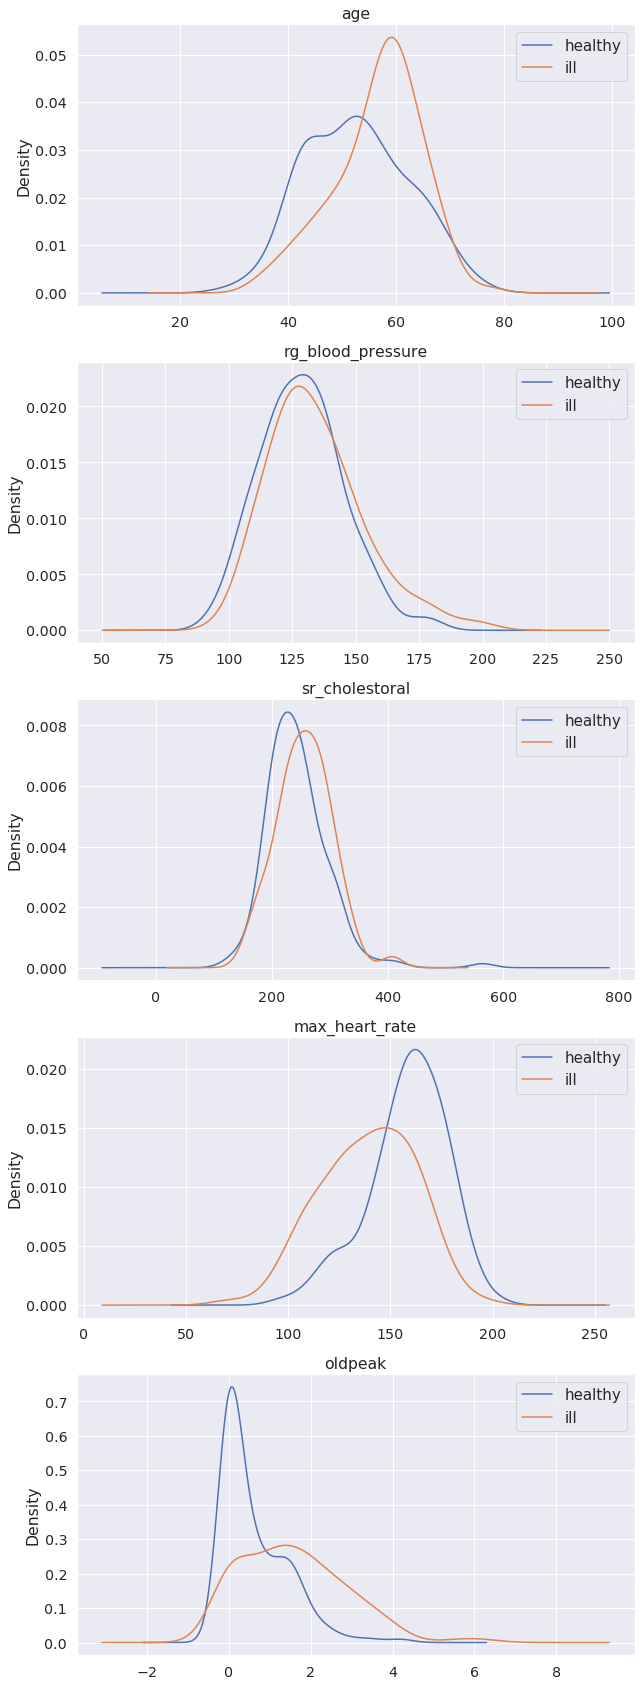

In [11]:
fig, axs = plt.subplots(len(num_features), figsize=(10, 30))

axs = axs.flatten()

for i, item in enumerate(num_features):
    df[df.ill == 0][item].plot.kde(title=item, ax=axs[i], label='healthy')
    df[df.ill == 1][item].plot.kde(title=item, ax=axs[i], label='ill')
    axs[i].legend(fontsize=15)

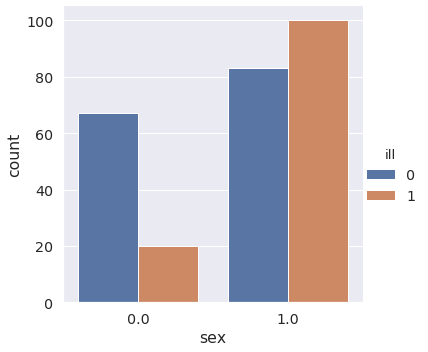

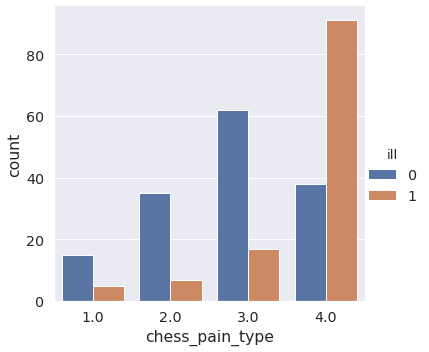

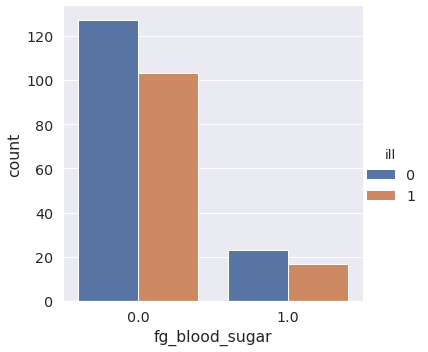

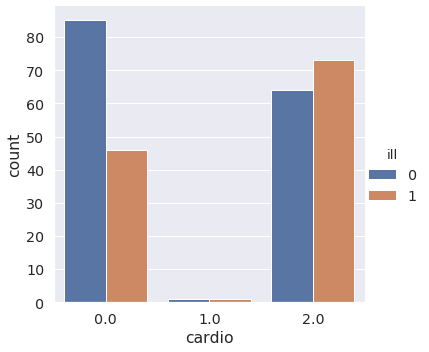

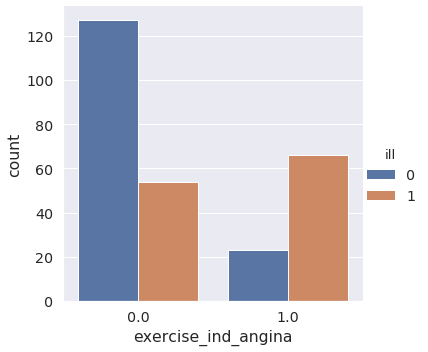

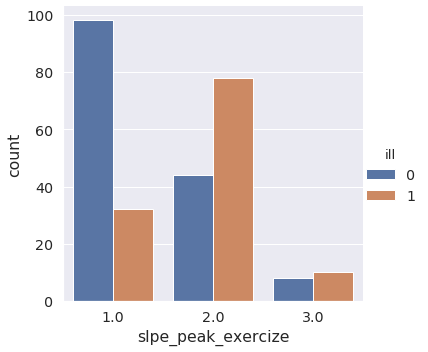

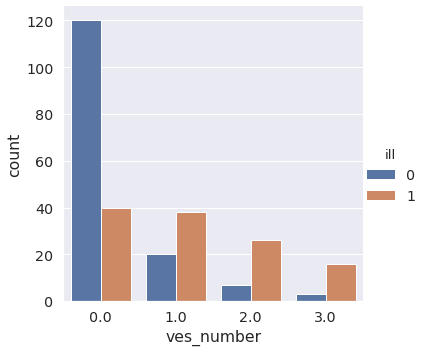

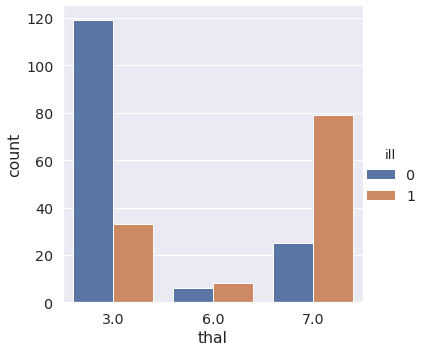

In [12]:
for i, item in enumerate(cat_features):
    sns.catplot(kind='count', data=df, x=item, hue='ill')

In [13]:
check_for_use_f = ['rg_blood_pressure']

In [14]:
train_features = num_features + cat_features

In [15]:
buf = df['slpe_peak_exercize'] == 2
df.loc[df['slpe_peak_exercize'] == 3, 'slpe_peak_exercize'] = 2
df.loc[buf, 'slpe_peak_exercize'] = 3

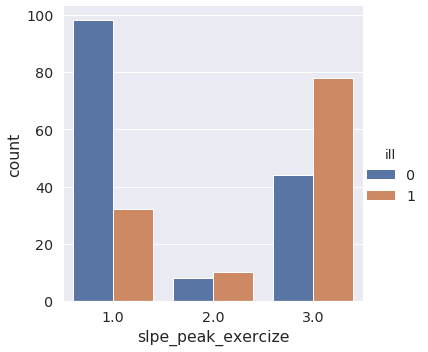

In [16]:
sns.catplot(kind='count', data=df, x='slpe_peak_exercize', hue='ill')

## Search best model

In [17]:
log_reg_ftrs = {
    'features': {
        'C':  hp.loguniform('x_C', -10, 1),
        'solver': 'liblinear',
        'tol': hp.loguniform('x_tol', -13, -1),
        'penalty': 'l2'
    },
    'model': LogisticRegression
}

random_forest_ftrs = {
    'features' : {
        'max_depth': hp.choice('max_depth', range(1, 10)),
        'max_features': hp.choice('max_features', range(1,10)),
        'n_estimators': hp.choice('n_estimators', range(10,100)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
        'min_samples_split': hp.choice('min_samples_split', range(2, 20)),
        'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 20)),
        'random_state': SEED
    },
    'model': RandomForestClassifier
}
    
xgb_ftrs = {
    'features' : {
        'n_estimators': hp.choice('n_estimators', np.arange(3, 150, 5)),
        'learning_rate': hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(1, 10, dtype=int)),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0, 10, 0.5),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'objective': hp.choice('objective', ('reg:gamma', 'reg:squarederror')),
        'seed':SEED
    },
    'model': XGBClassifier
}    

In [18]:
hp_params = {
    'n_fold': 5,
    'metric': roc_auc_score
}

In [19]:
def get_model_est(model, metric, X, y, folds = 5, params={}):  
    return cross_val_score(model,
                     X,
                     y,
                     cv=KFold(folds, shuffle=True, random_state=SEED),
                     scoring=make_scorer(metric)).mean()

In [20]:
def get_model_est_hyper_opt(params):
    model_cnstr = params['model_and_ftrs_space']['model']
    ftrs = params['model_and_ftrs_space']['features']
    metric = params['metric']
    n_fold = params['n_fold']
        
    model = model_cnstr(**ftrs)
        
    return -cross_val_score(model,
                           X,
                           y,
                           cv=KFold(n_fold, shuffle=True, random_state=SEED),
                           scoring=make_scorer(metric)).mean()

In [21]:
def get_model_est_features_enc(model, metric, X, y, encoder, cat_features):
    k_fold = KFold(5, shuffle=True, random_state=SEED)
    metrics = []

    for train_ind, test_ind in k_fold.split(X, y):
        X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

        enc = encoder(cols=cat_features)

        X_train = enc.fit_transform(X_train, y_train)
        model.fit(X_train, y_train)

        metrics.append(metric(y_test, model.predict(enc.transform(X_test))))

    return np.array(metrics).mean()

In [22]:
X = df[train_features]
y = df['ill']

### Random Forest

In [23]:
hp_params['model_and_ftrs_space'] = random_forest_ftrs

In [24]:
bst_prms_rndm_frst = space_eval(hp_params['model_and_ftrs_space']['features'],fmin(fn=get_model_est_hyper_opt, space=hp_params, algo=tpe.suggest, max_evals=200, trials=Trials()))

100%|██████████| 200/200 [01:02<00:00,  3.18trial/s, best loss: -0.8589878871128871]


In [25]:
bst_prms_rndm_frst

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 2,
 'min_samples_leaf': 6,
 'min_samples_split': 7,
 'n_estimators': 71,
 'random_state': 0}

## Xgboost

In [26]:
hp_params['model_and_ftrs_space'] = xgb_ftrs

In [27]:
bst_prms_xgboost = space_eval(hp_params['model_and_ftrs_space']['features'], fmin(fn=get_model_est_hyper_opt, space=hp_params, algo=tpe.suggest, max_evals=150, trials=Trials()))

100%|██████████| 150/150 [00:18<00:00,  8.16trial/s, best loss: -0.8586090992340992]


In [28]:
bst_prms_xgboost

{'colsample_bytree': 0.7000000000000001,
 'gamma': 0.5,
 'learning_rate': 0.225,
 'max_depth': 1,
 'n_estimators': 128,
 'objective': 'reg:squarederror',
 'seed': 0,
 'subsample': 0.65}

## LogisticRegression

In [31]:
hp_params['model_and_ftrs_space'] = log_reg_ftrs

In [33]:
bst_prms_log_reg = space_eval(hp_params['model_and_ftrs_space']['features'], fmin(fn=get_model_est_hyper_opt, space=hp_params, algo=tpe.suggest, max_evals=150, trials=Trials()))

100%|██████████| 150/150 [00:03<00:00, 43.57trial/s, best loss: -0.8543150599400601]


## Checking modelling with other features

In [34]:
train_new = [
    feature for feature in train_features if feature not in check_for_use_f
]

In [35]:
X = df[train_new]

In [36]:
hp_params['model_and_ftrs_space'] = random_forest_ftrs

In [37]:
bst_prms_rndm_frst_new = space_eval(hp_params['model_and_ftrs_space']['features'],fmin(fn=get_model_est_hyper_opt, space=hp_params, algo=tpe.suggest, max_evals=200, trials=Trials()))

100%|██████████| 200/200 [01:02<00:00,  3.18trial/s, best loss: -0.8649333999333999]


In [38]:
get_model_est(LogisticRegression(), roc_auc_score, df[train_new], df['ill'])

0.8533410339660341

In [39]:
get_model_est(
    RandomForestClassifier(**bst_prms_rndm_frst ), roc_auc_score, df[train_features],
    df['ill'])

0.8589878871128871

In [40]:
get_model_est_features_enc(RandomForestClassifier(**bst_prms_rndm_frst), roc_auc_score, df[train_new],
                           df['ill'], CatBoostEncoder, cat_features)

0.8270627289377288

## Get best model

In [41]:
best_model = RandomForestClassifier(**bst_prms_rndm_frst_new)
best_model.fit(df[train_new], df['ill'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=13, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=56,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [42]:
roc_auc_score(df.ill, best_model.predict_proba(df[train_new])[:, 1])

0.9487222222222222

In [43]:
COST_FN = 5

In [44]:
def get_opt_thresh(model, X, y):
    pred_p = model.predict_proba(X)[:, 1]

    threshs = np.arange(0, 1.01, 0.01)

    max_f1 = 0
    opt_thresh = 0

    for thresh in threshs:
        pred_c = pred_p >= thresh

        tn, fp, fn, tp = confusion_matrix(y, pred_c).ravel()

        if tp + fp == 0:
            continue

        recall = tp / (tp + COST_FN * fn)
        precision = tp / (tp + fp)

        f1 = 2 / (1 / recall + 1 / precision)

        if f1 > max_f1:
            max_f1 = f1
            opt_thresh = thresh

    return opt_thresh

In [45]:
best_thresh = get_opt_thresh(best_model, df[train_new], df['ill'])

In [48]:
best_thresh

0.24

In [46]:
recall_score(df['ill'], best_model.predict_proba(df[train_new])[:, 1] > best_thresh)

0.9916666666666667

In [47]:
precision_score(df['ill'], best_model.predict_proba(df[train_new])[:, 1] > best_thresh)

0.6761363636363636